## Facial Expression Classification, based on Facial Landmarks using Machine Learning (KNN / linear-SVM). ##


**Introduction and Brief Overview**

In the present project, an algorithm that classifies facial expression from raw images and videos will be developed. The dataset used to train the algorithm is the CK+ dataset containing the following emotions: "**anger**", "**contempt**", "**disgust**", "**fear**", "**happiness**", "**sadness**", "**surprise**", and is cited at the bottom of this cell. The process involves four steps.

1. Importing required libraries.
2. Detection of facial landmarks and extraction of feature vectors for the CK+ dataset. 
3. Application of **k - Nearest Neighbors** (using Minkowski instead of Euclidean distance as metric) and **linear Support Vector Machines** and evaluation of classification quality.
4. Test on an image and a video of myself showing different emotions.

**References**

**[1]** P. Lucey, J. F. Cohn, T. Kanade, J. Saragih, Z. Ambadar and I. Matthews, "The Extended Cohn-Kanade Dataset (CK+): A complete dataset for action unit and emotion-specified expression," 2010 IEEE Computer Society Conference on Computer Vision and Pattern Recognition - Workshops, San Francisco, CA, USA, 2010, pp. 94-101, doi: 10.1109/CVPRW.2010.5543262.

**[2]** Van Gent, P. (2016). Emotion Recognition Using Facial Landmarks, Python, DLib and OpenCV. A tech blog about fun things with Python and embedded electronics. Retrieved from: http://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-landmarks/


**1. Importing Required Libraries**



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import dlib
import glob
import random
import math
import sklearn
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from keras.preprocessing.image import img_to_array
from sklearn import metrics

.................  .................  .................  .................  .................  .................  .................  .................  .................  .................  .................  .................  .................  

**2. Detection of facial landmarks and extraction of feature vectors for the CK+ dataset.**

In [2]:
# Emotion classes
emotions = ["anger", "contempt", "disgust", "fear", "happiness", "sadness", "surprise"] 

# Human face detector and landmarks predictor, using dlib library.
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Setting up of CLAHE - adaptive histogram equalization, in order to enhance contrast in dataset images and 
# make the faces more distinguishable
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
data = {}

The following code-block is inspired by: **[2]** and describes the process of feature vector extraction from the images in the CK+ dataset and as a result a final form of the train and test data is returned, along with the corresponding class-labels.

In [3]:
# Define a function to get the CK+ dataset of faces from local folder, shuffle them 
# and split them in a desired train/test ratio (80%/20%).
def get_files(emotion): 
    files = glob.glob("dataset/%s/*" %emotion)
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] 
    prediction = files[-int(len(files)*0.2):] 
    return training, prediction

# Define a function to: 
# 1. Get landmarks from each image.
# 2. Draw landmarks on each image.
# 3. Store X and Y coordinates on xlist and ylist respectivelly.
# 4. Find center of gravity (c.o.g) of detected points and create vectors between c.o.g and every other detected point.
def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): 
        shape = predictor(image, d) 
        xlist = []
        ylist = []
        for i in range(0,68): 
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist]
        ycentral = [(y-ymean) for y in ylist]
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(x)
            landmarks_vectorised.append(y)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1:
        data['landmarks_vestorised'] = "error"
        
# Define function to: 
# 1. Apply grayscale and CLAHE to CK+ dataset images to enhance the contrast and make the landmark detection easier.
# 2. Extract the feature vectors from the CK+ dataset.
# 3. Store feature vectors into final train and test dataset arrays and also store the corresponding class labels.
def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for emotion in emotions:
        print("Creating training and validation data of: %s" %emotion)
        training, prediction = get_files(emotion)

        for item in training:
            image = cv2.imread(item) 
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                training_data.append(data['landmarks_vectorised']) 
                training_labels.append(emotion)
        for item in prediction:
            image = cv2.imread(item)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                prediction_data.append(data['landmarks_vectorised'])
                prediction_labels.append(emotion)
    return training_data, training_labels, prediction_data, prediction_labels


.................  .................  .................  .................  .................  .................  .................  .................  .................  .................  .................  .................  .................  

**3.a. Application of k - Nearest Neighbors algorithm and evaluation of classification quality.**

In [4]:
# Define the final train/validation sets and their corresponding labels.
training_data, training_labels, prediction_data, prediction_labels = make_sets()


Creating training and validation data of: anger
Creating training and validation data of: contempt
Creating training and validation data of: disgust
Creating training and validation data of: fear
Creating training and validation data of: happiness
Creating training and validation data of: sadness
Creating training and validation data of: surprise


In [5]:
# Convert the dataset to arrays.
npar_train = np.array(training_data) 
npar_trainlabs = np.array(training_labels)
npar_test = np.array(prediction_data)
npar_testlabs = np.array(prediction_labels)

In [6]:
# Apply a distance-based machine learning algorithm (KNN)
knn = KNeighborsClassifier(n_neighbors=1, metric = 'minkowski') 
#best results with 1 neighbor but feel free to change to 3,5 etc... (see more at: Conclusion Notes)
knn.fit(npar_train,npar_trainlabs)
y_pred = knn.predict(npar_test)

Implementing KNN..
Accuracy of KNN: 0.84375
gettin accuracies...
Confusion Matrix of KNN...


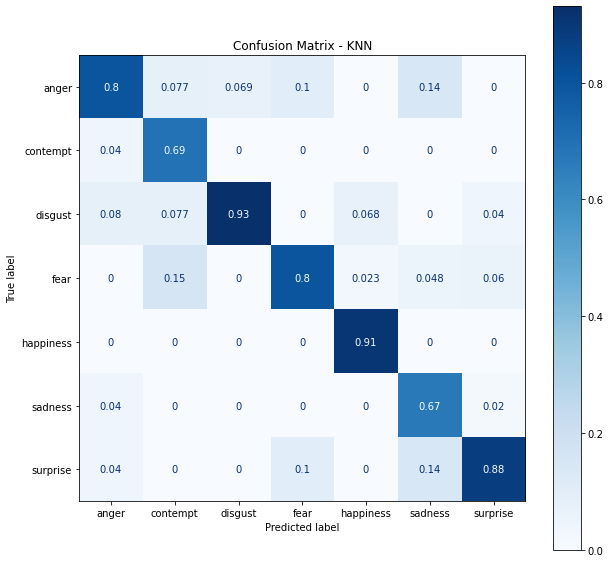

In [7]:
# Quality of Classification via:
print("Implementing KNN..")
# 1. Classification Accuracy.
print("Accuracy of KNN:", metrics.accuracy_score(npar_testlabs, y_pred))
# 2. Confusion Matrix.
print("gettin accuracies...")
print("Confusion Matrix of KNN...")
fig, ax = plt.subplots(figsize=(10, 10)) #change size to (8,8) or (6,6) if confusion matrix size is too big!
disp = plot_confusion_matrix(knn, npar_test, npar_testlabs, display_labels = emotions, cmap=plt.cm.Blues, normalize = 'pred', ax=ax)
disp.ax_.set_title("Confusion Matrix - KNN")
plt.show()

# Recognition accuracy varies between 67% and 79% with KNN

.................  .................  .................  .................  .................  .................  .................  .................  .................  .................  .................  .................  .................  

**3.b. Application of linear SVM algorithm and evaluation of classification quality.**

Implementing linear SVM ...
gettin accuracies...
Accuracy of linear SVM: 0.875
Confusion matrix of SVM...


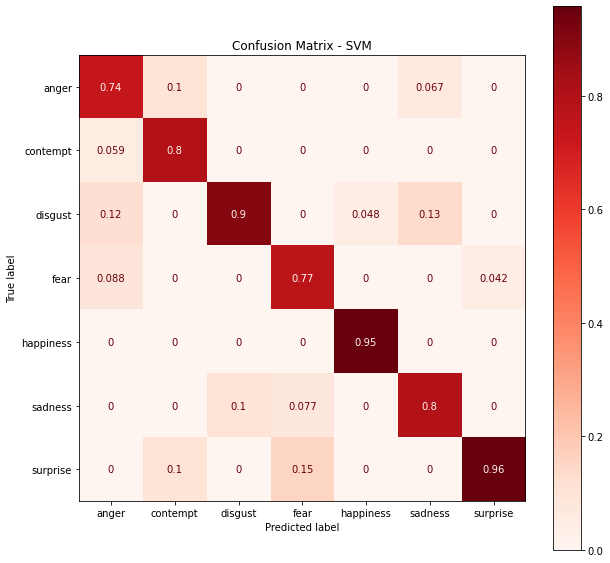

In [8]:
print("Implementing linear SVM ...")
clf = SVC(kernel='linear', probability = True, tol=1e-3, random_state=0)
clf.fit(npar_train, training_labels)

print("gettin accuracies...")
print("Accuracy of linear SVM:", clf.score(npar_test,npar_testlabs))

print("Confusion matrix of SVM...")
fig, ax = plt.subplots(figsize=(10, 10)) #change size to (8,8) or (6,6) if confusion matrix size is too big!
disp = plot_confusion_matrix(clf, npar_test, npar_testlabs, display_labels = emotions, cmap=plt.cm.Reds, normalize = 'pred', ax=ax)
disp.ax_.set_title("Confusion Matrix - SVM")
plt.show()

# Recognition accuracy varies between 80% and 90% with SVM

.................  .................  .................  .................  .................  .................  .................  .................  .................  .................  .................  .................  .................  

**4. Test on an image and a video of myself showing different emotions.**

press "space" to continue ;)
Input Image


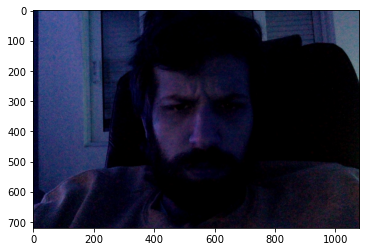

Grayscaled Image


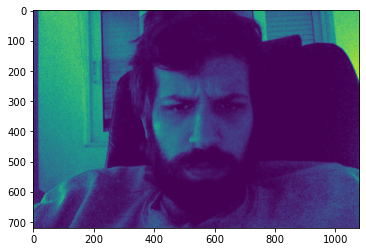

Contrast Enhanced Image


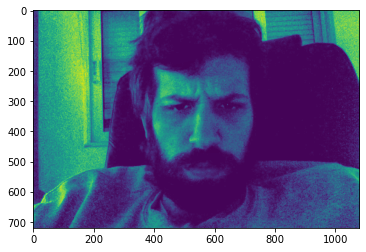

Self Image with Facial Landmarks


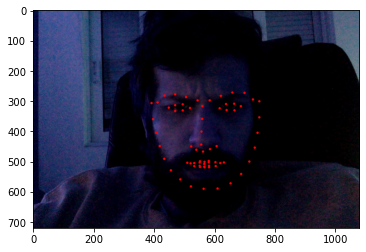

Self Image with Emotion Output


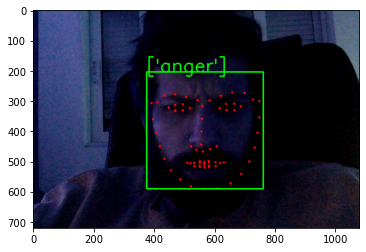

['anger']


In [9]:
##### TEST ON IMAGE ##### sample emotion prediction via SVM

print ('press "space" to continue ;)')
image_self = cv2.imread("self_photo.jpg")
# Show input image
cv2.imshow('Input Image', image_self)
cv2.waitKey(0)
# Print also on jupyter notebook
print("Input Image")
plt.imshow(image_self)
plt.show()
# Show grayscaled image
gray = cv2.cvtColor(image_self, cv2.COLOR_BGR2GRAY)
cv2.imshow('Grayscaled Image', gray)
cv2.waitKey(0)
# Print also on jupyter notebook
print("Grayscaled Image")
plt.imshow(gray)
plt.show()
# Show contrast-enhanced image
clahe_image = clahe.apply(gray)
cv2.imshow('Contrast-enhanced Image, via CLAHE', clahe_image)
cv2.waitKey(0)
# Print also on jupyter notebook
print("Contrast Enhanced Image")
plt.imshow(clahe_image)
plt.show()

# Extract feature vectors from an image and store them in a structure like before.
detections = detector(clahe_image, 1)
for k,d in enumerate(detections): 
    shape = predictor(clahe_image, d) 
    xlist = []
    ylist = []
    for i in range(0,68): 
        xlist.append(float(shape.part(i).x))
        ylist.append(float(shape.part(i).y))
    xmean = np.mean(xlist)
    ymean = np.mean(ylist)
    xcentral = [(x-xmean) for x in xlist]
    ycentral = [(y-ymean) for y in ylist]
    new_sample_vectorised = []
    for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
        new_sample_vectorised.append(x)
        new_sample_vectorised.append(y)
        meannp = np.asarray((ymean,xmean))
        coornp = np.asarray((z,w))
        dist = np.linalg.norm(coornp-meannp)
        new_sample_vectorised.append(dist)
        new_sample_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
if len(detections) < 1:
    print("error")

# Reshape the new test-sample for further classification via the already trained SVM algorithm via clf.predict().
new_sample_vectorised=np.array(new_sample_vectorised)
new_sample_vectorised=new_sample_vectorised.reshape(1,-1)

final_emotion = clf.predict(new_sample_vectorised)
final_emotion = np.array2string(final_emotion)

# Draw a green box around the detected face and print the output emotion.
for n in range(0,68):
    x = shape.part(n).x
    y = shape.part(n).y
    cv2.circle(image_self, (x,y),4,(255,0,0),-1)

cv2.imshow('Self Image with Facial Landmarks', image_self)
cv2.waitKey(0)
# Print also on jupyter notebook
print("Self Image with Facial Landmarks")
plt.imshow(image_self)
plt.show()

# Draw the landmarks detected on the face for completeness purposes.
for face in detections:
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()

cv2.rectangle(image_self,(x1,y1),(x2,y2),(0,255,0),3)
cv2.putText(image_self, final_emotion, (x1,y1), cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
cv2.imshow('Self Image with Emotion Output', image_self)
cv2.waitKey(0)
# Print also on jupyter notebook
print("Self Image with Emotion Output")
plt.imshow(image_self)
plt.show()

print(final_emotion)



['surprise']


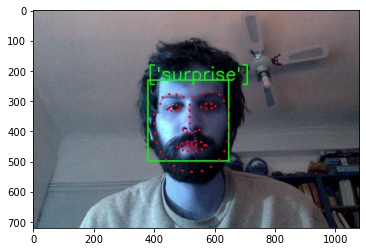

['surprise']


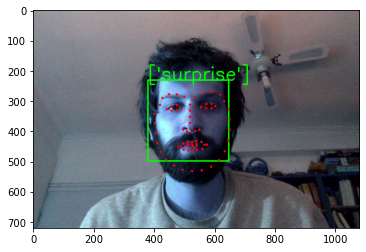

['surprise']


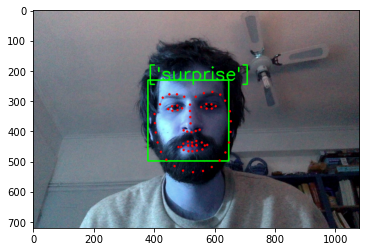

['surprise']


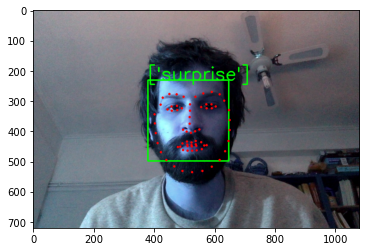

['surprise']


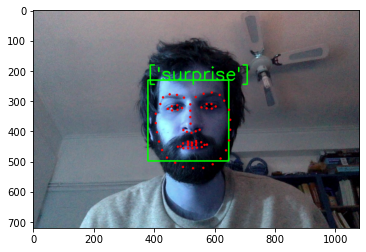

['surprise']


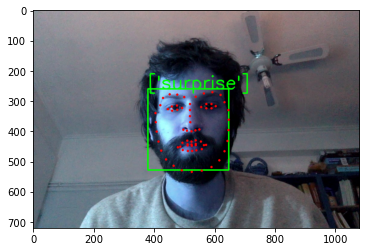

In [11]:
##### TEST ON VIDEO ##### sample frame emotion prediction via KNN

# Τest on captured video of myself showing random emotions!
cap = cv2.VideoCapture('self_video.mov')

if (cap.isOpened()== False):
    print("Error opening video stream or file")

while(cap.isOpened()):
    ret, frame = cap.read()

    if ret == True:
        # Extract feature vectors from every frame of a video and store them in a structure like before
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        clahe_image = clahe.apply(gray)
        detections = detector(clahe_image, 1)
        for k,d in enumerate(detections): 
            shape = predictor(clahe_image, d) 
            xlist = []
            ylist = []
            for i in range(0,68): 
                xlist.append(float(shape.part(i).x))
                ylist.append(float(shape.part(i).y))
                xmean = np.mean(xlist)
                ymean = np.mean(ylist)
                xcentral = [(x-xmean) for x in xlist]
                ycentral = [(y-ymean) for y in ylist]
                new_sample_vectorised = []
                for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
                    new_sample_vectorised.append(x)
                    new_sample_vectorised.append(y)
                    meannp = np.asarray((ymean,xmean))
                    coornp = np.asarray((z,w))
                    dist = np.linalg.norm(coornp-meannp)
                    new_sample_vectorised.append(dist)
                    new_sample_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        if len(detections) < 1:
            print("error")
            
        # Reshape the new test sample in order to be classified via the already trained
        # KNN algorithm via knn.predict()
        new_sample_vectorised=np.array(new_sample_vectorised)
        new_sample_vectorised=new_sample_vectorised.reshape(1,-1)
        final_emotion = knn.predict(new_sample_vectorised)
        final_emotion = np.array2string(final_emotion)
        print(final_emotion)

        # Once the face is detected by the dlib detector, i draw a green rectangle shape that follows
        # the face in each video frame and prints the output emotion in each frame consequently.
        for face in detections:
         x1 = face.left()
         y1 = face.top()
         x2 = face.right()
         y2 = face.bottom()
         cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0),3)
         cv2.putText(frame, final_emotion, (x1,y1), cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
        
        # Print the 68 landmark points on the face at the same time for completeness
        for n in range(0,68):
            x = shape.part(n).x
            y = shape.part(n).y
            cv2.circle(frame, (x,y),4,(255,0,0),-1)
        # Also print each frame of the video with the predicted emotion on Jupyter Notebook
        cv2.imshow('Self Video Emotion Capture',frame)
        plt.imshow(frame)
        plt.show()
        
    key = cv2.waitKey(1)
    if key == 27:
        break 
        


# You can press "esc" to end the video earlier!
# Below you can see 

**Important Notes**

1. In kNN implementation i used the Minkowski Distance metric, since all feature vectors, between the central point (c.o.g) and the other landmark points on a detected face, are positive. By using Minkowski distance, in the present implementation, a classification accuracy increase of about 10% is noticed when compared to the traditional Euclidean Distance metric.


2. The kNN algorithm offers better results when number of neighbors (k) is equal to "1", since train/test data are the same data that were randomly split and they have high similarity.


3. Linear SVM outperformed kNN, which indicates that classes are easilly seperable.

**Extra Notes**

1. In the past i have trained a CNN to recognize emotions on a live video with OpenCV using CascadeClassifier to detect faces in images. You can find more information in my github page: https://github.com/konstgyftodimos